# EnsembleOptimizer
In this notebook we demonstrate the basic usage of the `EnsembleOptimizer`, and how one can employ an ensemble of models (cluster expansions) to make predictions for the uncertainty of derived properties.

The `EnsembleOptimizer` will split the total dataset into many different training sets. Each of these will be used to train a cluster expansion, yielding a collection or an ensemble of cluster expansions.

The `EnsembleOptimizer` will thus produce a vector of predicted energies for a single structure. The spread (standard deviation) of these energies can to some extent be interpreted as the "uncertainty" for the given structure.

This can for example be useful when selecting training structures as described in David Kleiven *et al.*, J. Phys. Energy **3**, 034012 (2021).

Furthermore each cluster expansion in the ensemble can be used to sample thermodynamic properties with MCMC, as demonstrated in the [icet paper](https://doi.org/10.1002/adts.201900015). This allows one for example to evaluate the sensitivity of the temperature-composition phase diagram with respect to training structures.

Note: Generating an ensemble of models can also be done in a Bayesian framework, see e.g. [this example](https://gitlab.com/materials-modeling/hiphive-examples/-/tree/master/advanced/bayesian_phonon_dispersions) for training force constant models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterSpace, StructureContainer
from trainstation import EnsembleOptimizer

try:
    import seaborn as sns
    sns.set_context('notebook')
except ImportError:
    print('sad')

In order to highlight how the uncertainty of structures works in practice we construct cluster expansions from training structures with a maximum Pd concentration of 50%.
This should lead to models with large uncertainty for Pd concentrations above 50%, since the models have not seen (been trained on) any such structures.

In [2]:
# parameters
cutoffs = [8.0, 6.5, 6.0]

# setup CS and get fit data
db = connect('../../tutorial/reference_data.db')
primitive_structure = db.get(id=1).toatoms()  # primitive structure
cs = ClusterSpace(structure=primitive_structure, cutoffs=cutoffs, chemical_symbols=['Ag', 'Pd'])
sc = StructureContainer(cluster_space=cs)

# Select only certain structures for demonstrations sake
for row in db.select():
    
    c_Pd = row.symbols.count('Pd') / row.natoms
    if c_Pd > 0.5:
        continue
    
    sc.add_structure(structure=row.toatoms(), user_tag=row.tag,
                     properties={'mixing_energy': row.mixing_energy})
A, y = sc.get_fit_data(key='mixing_energy')
print('Fit data shape', A.shape)

Fit data shape (374, 64)


In [3]:
# Train an ensemble of models
fit_method = 'least-squares'
ensemble_size = 100

eopt = EnsembleOptimizer((A, y), fit_method=fit_method, ensemble_size=ensemble_size)
eopt.train()

## Uncertainty predictions for structures
Next we evaluate the uncertainty for a large collection of structures.

In [4]:
from icet.tools import enumerate_structures

sizes = range(1, 9)
records = []
test_structures = []
for structure in enumerate_structures(primitive_structure, sizes, ['Pd', 'Ag']):
    c_Pd = structure.symbols.count('Pd') / len(structure)
    cv = cs.get_cluster_vector(structure)
    E_mean, E_std = eopt.predict(cv, return_std=True)
    
    #print(c_Pd, E_std, E_mean)
    row = dict(c_Pd=c_Pd, E_std=E_std, E_mean=E_mean)
    records.append(row)
    test_structures.append(structure)
df = pd.DataFrame(records)

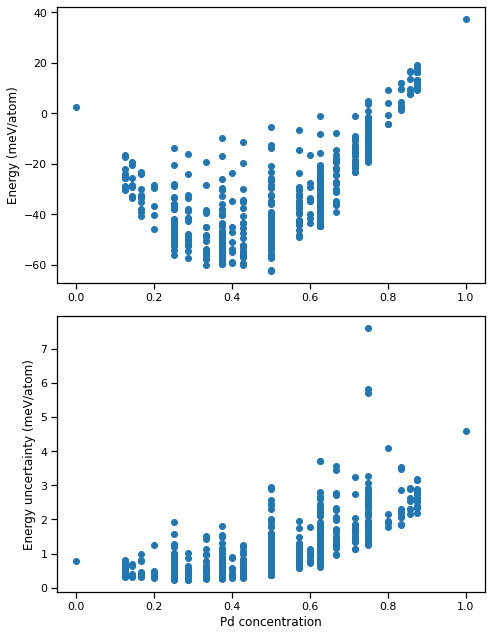

In [5]:
fig = plt.figure(figsize=(7, 9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(df.c_Pd, 1000 * df.E_mean, 'o')
ax2.plot(df.c_Pd, 1000 * df.E_std, 'o')

ax2.set_xlabel('Pd concentration')
ax1.set_ylabel('Energy (meV/atom)')
ax2.set_ylabel('Energy uncertainty (meV/atom)')

fig.tight_layout()
plt.show()

Here, we clearly see that structures with concentrations larger than 50% have much larger uncertainties, as expected. The uncertainty measure thus gives us a good indication of structures that are far away from the training structures and can therefore be used to suggest new training structures.

Selecting a new training structure can, e.g., be done with the cell below.

In [6]:
ind = df.E_std.idxmax()
structure = test_structures[ind]
print('New training structure suggestion:')
print(df.loc[ind])
print(structure)

New training structure suggestion:
c_Pd      0.750000
E_std     0.007598
E_mean    0.004762
Name: 27, dtype: float64
Atoms(symbols='Pd3Ag', pbc=True, cell=[[0.0, 0.0, 4.09], [0.0, 4.09, 0.0], [-4.09, 0.0, 0.0]])
